In [ ]:
# default_exp inspect

In [ ]:
# export
from typing import Iterable, Optional, Sequence, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from IPython.display import HTML
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2
%load_ext lab_black

# inspect

> Inspect models.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
def generate_linear_model_html(
    model,
    feature_names: Iterable[str],
    target_name: str,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    """Generate an HTML equation that characterizes a linear model.

    Model components are color-coded as follows:
    - target: red
    - intercept: purple
    - coefficients: green
    - features: blue

    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `y = b0 + b1 * x1 + ...`.
    - `feature_names`: feature names in the order in which they were
    given to the model.
    - `target_name` : Name of target variable `y`
    - `intercept_formatter`: Format specifier for model intercept
    - `coef_formatter`: Format specifier for model coefficients
    """
    if len(model.coef_) != len(feature_names):
        raise ValueError("len(model.coef_) != len(feature_cols)")
    model_string = f"""
        <span style='color:red'>{target_name}</span>
        = <span style='color:purple'>{model.intercept_:{intercept_formatter}}</span>
    """
    for coef, feature_col in zip(model.coef_, feature_names):
        model_string += f"""
            <span style='color:green'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
            * <span style='color:blue'>{feature_col}</span>
        """
    return model_string

In [ ]:
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

HTML(
    generate_linear_model_html(
        model=LinearRegression().fit(X_diabetes, y_diabetes),
        feature_names=X_diabetes.columns,
        target_name="progression",
    )
)

In [ ]:
# export
def generate_logistic_model_html(
    model,
    feature_names: Iterable[str],
    target_val_names: Iterable[str],
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    """Generate an HTML equation that characterizes a logistic
    regression model.

    Model components are color-coded as follows:
    - target: red
    - intercept: purple
    - coefficients: green
    - features: blue

    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `log-odds(y) = b0 + b1 * x1 + ...`.
    - `feature_names`: feature names in the order in which they were
    given to the model.
    - `target_val_names`: Names of the values of the target variable
    - `intercept_formatter`: Format specifier for model intercept
    - `coef_formatter`: Format specifier for model coefficients
    """
    for coefs in model.coef_:
        if len(coefs) != len(feature_names):
            raise ValueError("len(model.coef_) != len(feature_cols)")
    model_string = "<p>"
    for target_name, coefs, intercept in zip(
        target_val_names, model.coef_, model.intercept_
    ):
        model_string += f"""
            <span style='color:red'>log-odds({target_name})</span>
            = <span style='color:purple'>{intercept:{intercept_formatter}}</span>
        """
        for coef, feature_col in zip(coefs, feature_names):
            model_string += f"""
                <span style='color:green'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
                * <span style='color:blue'>{feature_col}</span>
            """
        model_string += "</p>"
    return model_string

In [ ]:
iris = sklearn.datasets.load_iris()
X_iris, y_iris = iris["data"], iris["target"]
y_iris = pd.Series(y_iris).map(
    {num: name for num, name in zip([0, 1, 2], iris["target_names"])}
)
X_iris = pd.DataFrame(X_iris, columns=iris["feature_names"])

lr_iris = LogisticRegression(max_iter=1_000).fit(X_iris, y_iris)
HTML(
    generate_logistic_model_html(
        model=lr_iris,
        feature_names=X_iris.columns,
        target_val_names=y_iris.unique(),
    )
)

In [ ]:
# export
def plot_2d_regression(
    model,
    X: pd.DataFrame,
    y: Union[np.array, pd.Series],
    cmap="viridis",
    tick_formatter: str = ".2f",
    ax=None,
    plot_data: bool = True,
):
    """Plot data and predictions for regression model with two features

    Parameters:
    - `model`: scikit-learn regression model
    - `X`: Feature matrix with at least two columns. The first two
    columns will be used.
    - `y`: Target values
    - `cmap`: Colormap
    - `ticket_formatter`: Tick label format specifier
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    - `plot_data`: Whether to plot the data points in addition to the
    model predictions.
    """

    def _plot_preds(model, X, y, ax, cmap):
        x_grid = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 100)
        y_grid = np.linspace(X.iloc[:, 1].max(), X.iloc[:, 1].min(), 100)

        preds = (
            model.fit(X, y)
            .predict(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            )
            .reshape(len(y_grid), len(x_grid))
        )
        preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
        return sns.heatmap(preds, cmap=cmap, vmin=y.min(), vmax=y.max(), ax=ax)

    if ax is None:
        fig, ax = plt.subplots()
    ax = _plot_preds(model=model, X=X, y=y, ax=ax, cmap=cmap)
    if plot_data:
        ax = _plot_data(X=X, y=y, ax=ax, cmap=cmap)
    _format_ticks(ax=ax, formatter=tick_formatter)
    return ax


def _plot_data(X, y, ax, cmap):
    X_normalized = MinMaxScaler().fit_transform(X) * 99
    ax.scatter(
        X_normalized[:, 0] + 0.5,
        X_normalized[:, 1].max() - X_normalized[:, 1] + 0.5,
        c=y,
        cmap=cmap,
        edgecolor="k",
        zorder=999,
    )
    ax.set(xlabel=X.columns[0], ylabel=X.columns[1])
    return ax


def _format_ticks(ax, formatter):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f"{float(label):{formatter}}" for label in labels])

    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([f"{float(label):{formatter}}" for label in labels])

In [ ]:
feature_cols = ["bmi", "bp"]
HTML(
    generate_linear_model_html(
        LinearRegression().fit(X_diabetes.loc[:, feature_cols], y_diabetes),
        feature_cols,
        "progression",
    )
)

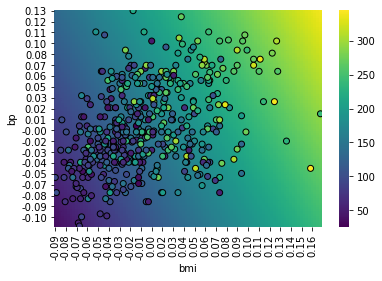

In [ ]:
ax = plot_2d_regression(
    model=LinearRegression(),
    X=X_diabetes.loc[:, feature_cols],
    y=y_diabetes,
)

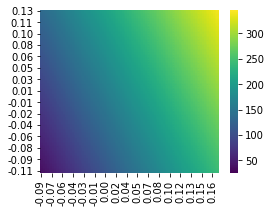

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
# fmt: off
plot_2d_regression(
    model=LinearRegression(), X=X_diabetes.loc[:, feature_cols], y=y_diabetes, ax=ax, plot_data=False
);

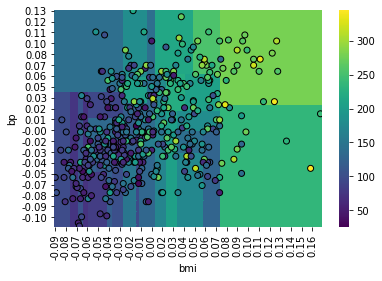

In [ ]:
ax = plot_2d_regression(
    model=DecisionTreeRegressor(min_samples_leaf=10),
    X=X_diabetes.loc[:, feature_cols],
    y=y_diabetes,
)

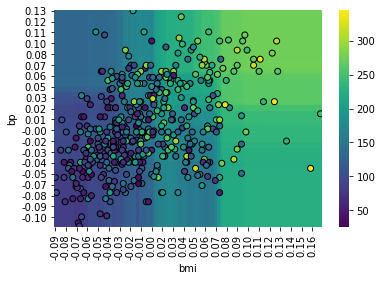

In [ ]:
ax = plot_2d_regression(
    model=RandomForestRegressor(min_samples_leaf=10),
    X=X_diabetes.loc[:, feature_cols],
    y=y_diabetes,
)

In [ ]:
# export
def plot_2d_classification(
    model,
    X: pd.DataFrame,
    y: Union[np.array, pd.Series],
    cmap=None,
    tick_formatter: str = ".2f",
    ax=None,
    plot_data: bool = True,
):
    """Plot data and predictions for classification model with two features

    Parameters:
    - `model`: scikit-learn classification model
    - `X`: Feature matrix with at least two columns. The first two
    columns will be used.
    - `y`: Target values
    - `cmap`: Colormap
    - `tick_formatter`: Tick label format specifier
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(model, X, y, ax, cmap):
        x_grid = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 100)
        y_grid = np.linspace(X.iloc[:, 1].max(), X.iloc[:, 1].min(), 100)

        preds = (
            model.fit(X, y)
            .predict(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            )
            .reshape(len(y_grid), len(x_grid))
        )
        y_vals = pd.unique(y)
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
        preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
        for col in preds:
            preds.loc[:, col] = preds.loc[:, col].map(label_to_num)
        ax = sns.heatmap(
            preds.astype(int),
            cmap=cmap,
        )
        return ax

    def _set_colorbar(ax, y):
        colorbar = ax.collections[0].colorbar
        r = colorbar.vmax - colorbar.vmin
        y_vals = pd.unique(y)
        colorbar.set_ticks(
            [colorbar.vmin + r / len(y_vals) * (0.5 + i) for i in range(len(y_vals))]
        )
        colorbar.set_ticklabels(y_vals)
        return colorbar

    def _wash_out(ax):
        rectangle = plt.Rectangle((0, 0), 100, 100, fc="w", alpha=0.5)
        ax.add_patch(rectangle)
        return ax

    y = pd.Series(y)
    y_vals = y.unique()

    cmap = sns.color_palette(None, len(y_vals)) if cmap is None else cmap
    if ax is None:
        fig, ax = plt.subplots()
    ax = _plot_preds(model=model, X=X, y=y, ax=ax, cmap=cmap)
    ax = _wash_out(ax)
    colorbar = _set_colorbar(ax, y)
    y_vals = pd.unique(y)
    if plot_data:
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
        ax = _plot_data(X=X, y=y.map(label_to_num), ax=ax, cmap=colorbar.cmap)
    _format_ticks(ax=ax, formatter=tick_formatter)
    return ax

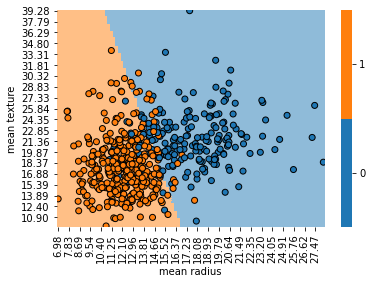

In [ ]:
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
ax = plot_2d_classification(LogisticRegression(), X_cancer.iloc[:, :2], y_cancer.values)

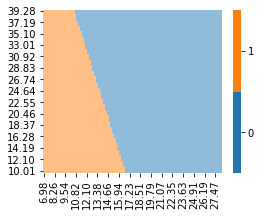

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
# fmt: off
plot_2d_classification(
    LogisticRegression(), X_cancer.iloc[:, :2], y_cancer.values, ax=ax, plot_data=False
);

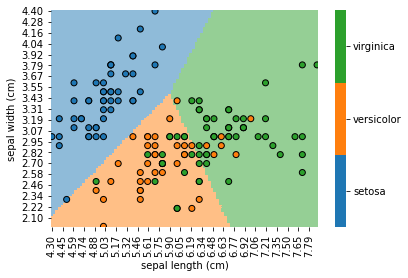

In [ ]:
ax = plot_2d_classification(LogisticRegression(), X_iris.iloc[:, :2], y_iris)

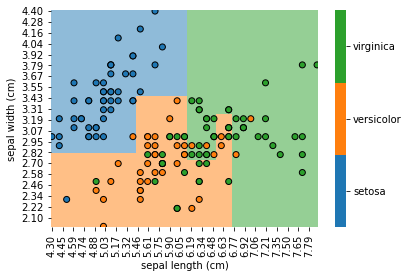

In [ ]:
from sklearn.tree import DecisionTreeClassifier

ax = plot_2d_classification(
    DecisionTreeClassifier(min_samples_leaf=5), X_iris.iloc[:, :2], y_iris
)

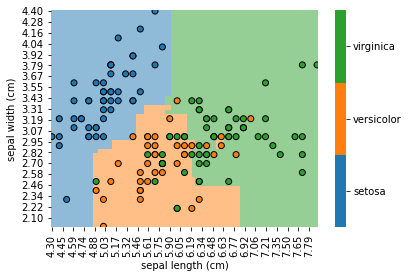

In [ ]:
from sklearn.ensemble import RandomForestClassifier

ax = plot_2d_classification(
    RandomForestClassifier(min_samples_leaf=5), X_iris.iloc[:, :2], y_iris
)

In [ ]:
# export
def plot_linear_coefs_vs_hparam(
    model, X: pd.DataFrame, y: Sequence, hparam: str, hparam_vals: Sequence[float]
):
    """Plot linear regression coefficients against a hyperparameter

    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `y = b0 + b1 * x1 + ...`.
    - `X`: Feature matrix
    - `y`: Target values
    - `hparam`: Name of hyperparameter
    - `hparam_vals`: Values of hyperparameter to use
    """
    setattr(model, hparam, hparam_vals[-1])
    model.fit(X, y)
    column_order = model.coef_.argsort()[::-1]
    X = X.iloc[:, column_order]

    coefs = []
    for val in hparam_vals:
        setattr(model, hparam, val)
        coefs.append(model.fit(X, y).coef_)

    fig, ax = plt.subplots()
    ax.plot(hparam_vals, coefs)
    ax.set(xlabel=hparam, ylabel="coefficient value")
    ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    return ax

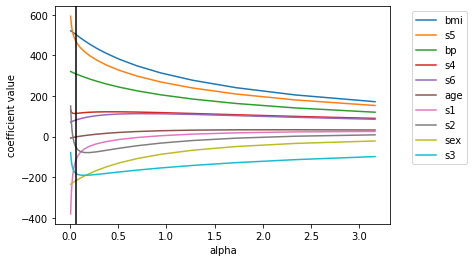

In [ ]:
ax = plot_linear_coefs_vs_hparam(
    model=Ridge(),
    X=X_diabetes,
    y=y_diabetes,
    hparam="alpha",
    hparam_vals=np.logspace(-2, 0.5, 20),
)

grid_ridge_diabetes = GridSearchCV(
    estimator=Ridge(),
    param_grid={"alpha": np.logspace(-2, -0.8, 20)},
    cv=KFold(10, shuffle=True, random_state=2),
)
grid_ridge_diabetes.fit(X_diabetes, y_diabetes)
# fmt: off
ax.axvline(grid_ridge_diabetes.best_params_["alpha"], c="k");

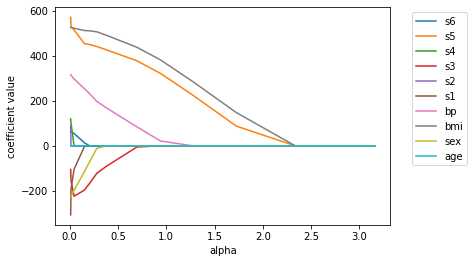

In [ ]:
from sklearn.linear_model import Lasso

# fmt: off
plot_linear_coefs_vs_hparam(
    model=Lasso(max_iter=10_000_000),
    X=X_diabetes,
    y=y_diabetes,
    hparam="alpha",
    hparam_vals=np.logspace(-2, 0.5, 20),
);

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1309066.6007960497, tolerance: 262.1009124434389
  model = cd_fast.enet_coordinate_descent(


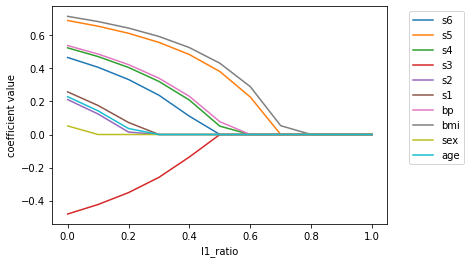

In [ ]:
from sklearn.linear_model import ElasticNet

# fmt: off
plot_linear_coefs_vs_hparam(
    model=ElasticNet(alpha=3),
    X=X_diabetes,
    y=y_diabetes,
    hparam="l1_ratio",
    hparam_vals=np.linspace(0, 1, 11),
);

In [ ]:
# export
def plot_logistic_coefs_vs_hparam(
    model, X: pd.DataFrame, y: Sequence, hparam: str, hparam_vals: Sequence[float]
):
    """Plot logistic regression coefficients against a hyperparameter

    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `log-odds(y) = b0 + b1 * x1 + ...`.
    - `X`: Feature matrix
    - `y`: Target values
    - `hparam`: Name of hyperparameter
    - `hparam_vals`: Values of hyperparameter to use
    """
    setattr(model, hparam, hparam_vals[-1])
    column_order = model.fit(X, y).coef_[0].argsort()[::-1]
    X = X.iloc[:, column_order]

    coef_arrays = []
    for val in hparam_vals:
        setattr(model, hparam, val)
        coef_arrays.append(model.fit(X, y).coef_)

    num_target_vals = len(set(y))
    if num_target_vals == 2:
        fig, ax = plt.subplots()
        ax.plot(hparam_vals, [coefs[0] for coefs in coef_arrays])
        axes = np.array(ax)[None]
    else:
        fig, axes = plt.subplots(
            num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
        )
        for target_val_num in range(num_target_vals):
            axes[target_val_num].plot(
                hparam_vals, [coefs[target_val_num] for coefs in coef_arrays]
            )
            axes[target_val_num].set_title(f"y={sorted(set(y))[target_val_num]}")
    axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    axes[0].set_ylabel("Coefficient Value")
    axes[-1].set_xlabel(hparam)
    return axes

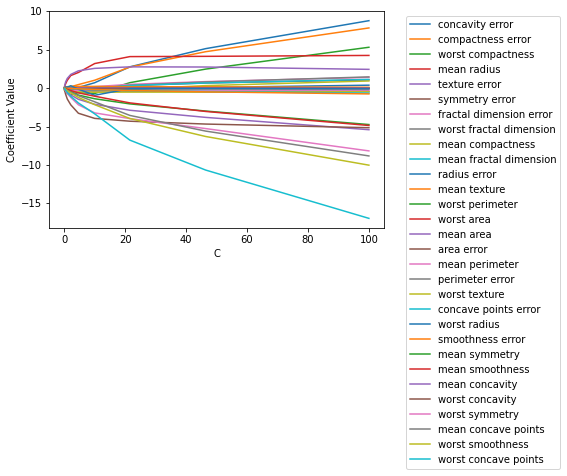

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(max_iter=10_000),
    X=X_cancer,
    y=y_cancer,
    hparam="C",
    hparam_vals=np.logspace(-1, 2, 10),
)

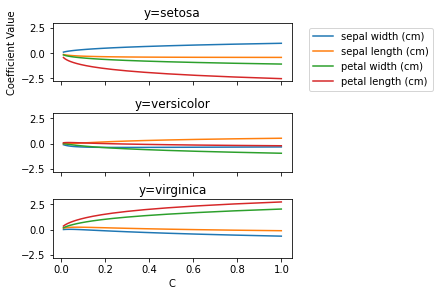

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(max_iter=1_000),
    X=X_iris,
    y=y_iris,
    hparam="C",
    hparam_vals=np.logspace(-2, 0, 20),
)

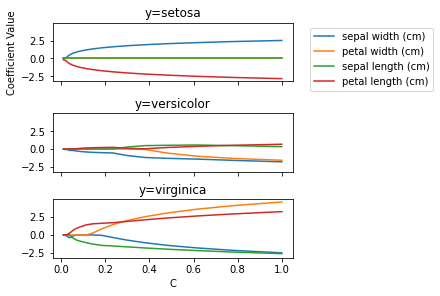

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(max_iter=1_000, solver="liblinear", penalty="l1"),
    X=X_iris,
    y=y_iris,
    hparam="C",
    hparam_vals=np.logspace(-2, 0, 20),
)

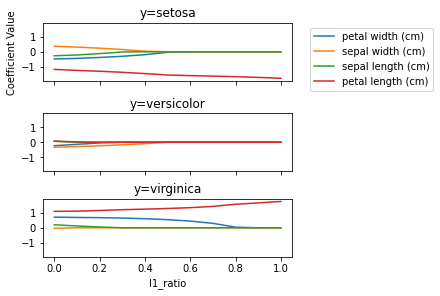

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(
        max_iter=10_000, solver="saga", penalty="elasticnet", C=0.1
    ),
    X=X_iris,
    y=y_iris,
    hparam="l1_ratio",
    hparam_vals=np.linspace(0, 1, 11),
)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_inspect.ipynb.
Converted 01_tune.ipynb.
Converted index.ipynb.
